In [4]:
# auto-load when code changes outside
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,'..')


## Torch data-loader
https://www.kaggle.com/mdteach/torch-data-loader-flicker-8k

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


In [3]:
#location of the data 
# data_location =  '/home/space/datasets/COA/generated-data-api'
data_location =  '../generated-data-api-small'
!ls $data_location

#reading the text data 

caption_file = data_location + '/captions.txt'
root_folder_images = data_location + '/images'
df = pd.read_csv(caption_file)
print("There are {} image to captions".format(len(df)))
df.head(7)


captions.txt       test_captions.txt  val_captions.txt
images             train_captions.txt
There are 60 image to captions


,image,caption
0,image_1.png,A A lion
1,image_2.png,A A lion rampant
2,image_3.png,A A lion passt
3,image_4.png,A A lion passt guard
4,image_5.png,A A lion's head
5,image_6.png,A B lion
6,image_7.png,A B lion rampant


Caption: A O lion rampant


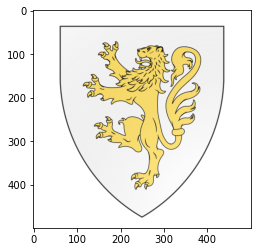

Caption: A O lion passt


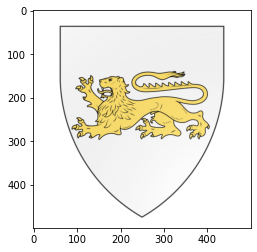

Caption: A O lion passt guard


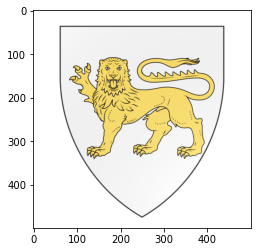

Caption: A O lion's head


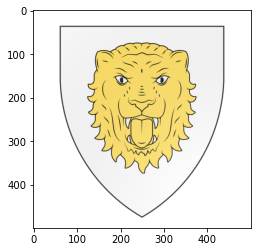

Caption: A S lion


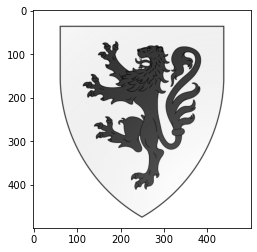

Caption: A S lion rampant


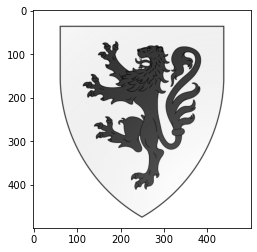

Caption: A S lion passt


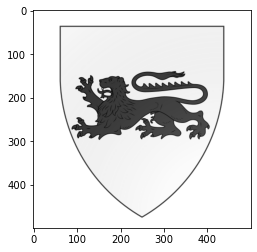

Caption: A S lion passt guard


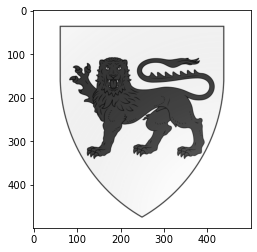

Caption: A S lion's head


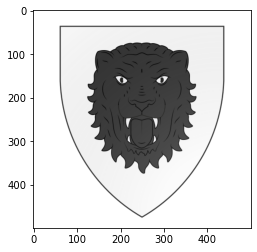

Caption: A G lion


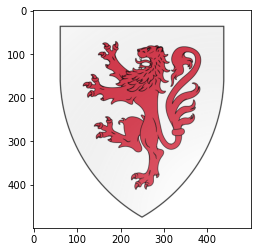

In [4]:
#select any index from the whole dataset 
#single image has 5 captions
#so, select indx as: 1,6,11,16...
for i in range(11, 21):
    image_path = data_location + '/images/'+ df.iloc[i,0]
    print("Caption:", df.iloc[i,1])
    img=mpimg.imread(image_path)
    plt.imshow(img)
    plt.show()



# Split Data into Training/Test datasets 

In [6]:
def train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test


# data_location =  '/home/space/datasets/COA/generated-data-api-small'
data_location =  '../generated-data-api-small'
caption_file = data_location + '/captions.txt'
root_folder_images = data_location + '/images'
df = pd.read_csv(caption_file)

train, validate, test = train_validate_test_split(df, train_percent=.6, validate_percent=.2, seed=None)


train_annotation_file = data_location + '/train_captions.txt'
val_annotation_file  = data_location + '/val_captions.txt'
test_annotation_file  = data_location + '/test_captions.txt'

train.to_csv(train_annotation_file, sep=',',index=False)
test.to_csv(test_annotation_file, sep=',',index=False)
validate.to_csv(val_annotation_file, sep=',',index=False)


print("There are {} total images".format(len(df)))

caption_file = data_location + '/train_captions.txt'
df1 = pd.read_csv(caption_file)
print("There are {} train images".format(len(df1)))

caption_file = data_location + '/val_captions.txt'
df2 = pd.read_csv(caption_file)
print("There are {} val images".format(len(df2)))

caption_file = data_location + '/test_captions.txt'
df3 = pd.read_csv(caption_file)
print("There are {} test images".format(len(df3)))

There are 60 total images
There are 36 train images
There are 12 val images
There are 12 test images


Caption: image_2.png A A lion rampant
(500, 500, 4)


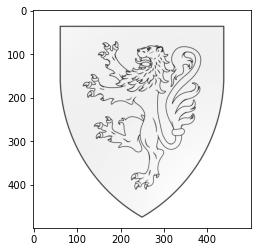

Caption: image_3.png A A lion passt
(500, 500, 4)


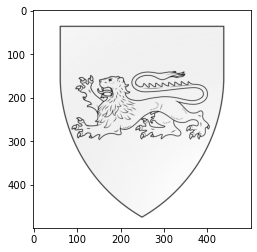

Caption: image_4.png A A lion passt guard
(500, 500, 4)


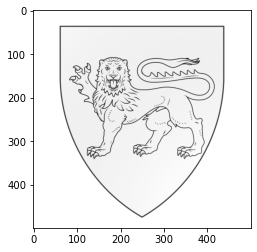

Caption: image_5.png A A lion's head
(500, 500, 4)


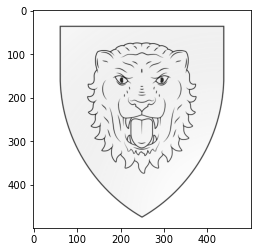

Caption: image_6.png A B lion
(500, 500, 4)


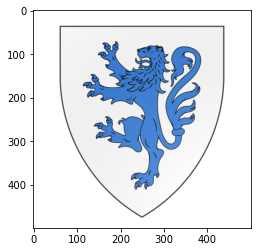

Caption: image_7.png A B lion rampant
(500, 500, 4)


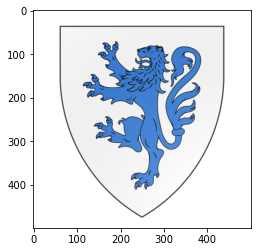

Caption: image_8.png A B lion passt
(500, 500, 4)


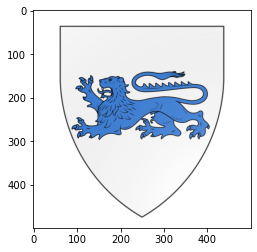

Caption: image_9.png A B lion passt guard
(500, 500, 4)


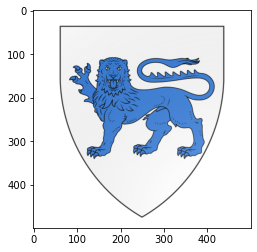

Caption: image_10.png A B lion's head
(500, 500, 4)


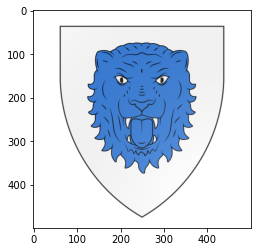

Caption: image_11.png A O lion
(500, 500, 4)


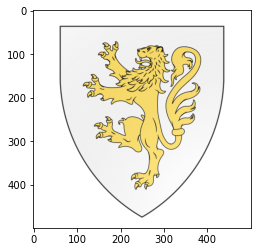

Caption: image_12.png A O lion rampant
(500, 500, 4)


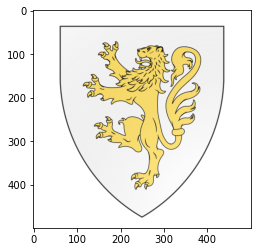

In [ ]:
for i in range(1, 20):
    image_path = data_location + '/images/'+ df.iloc[i,0]
    print("Caption:", df.iloc[i,0], df.iloc[i,1])
    img=mpimg.imread(image_path)
    print(img.shape)
    plt.imshow(img)
    plt.show()


In [3]:
#imports 
import os
import torch
import spacy
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
from PIL import Image
from datetime import datetime
from tqdm import tqdm
from time import sleep

from src.baseline.vocabulary import Vocabulary
from src.baseline.coa_dataset import CoADataset
from src.baseline.caps_collate import CapsCollate
from src.baseline.data_loader import get_loader

# torch.cuda.empty_cache()


ModuleNotFoundError: No module named 'src'

In [7]:
!export CUDA_VISIBLE_DEVICES=0

In [6]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

device

device(type='cpu')

In [9]:
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled

# Image Captioning With Attention - Pytorch

In [7]:
#show the tensor image
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    

def print_time(text):
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("{} @ Time = {}".format(text, current_time))


In [8]:
#setting the constants
# BATCH_SIZE = 512
BATCH_SIZE = 5
NUM_WORKER = 1 #### this needs multi-core
freq_threshold = 5
# 30 minutes to create those, as it's baseline, i ran it several times and it's the same
vocab = Vocabulary(freq_threshold)
vocab.stoi = {'<PAD>': 0, '<SOS>': 1, '<EOS>': 2, '<UNK>': 3, 'g': 4, 'v': 5, 'b': 6, 'cross': 7, 'lion': 8, 'passt': 9, 's': 10, 'a': 11, 'eagle': 12, 'o': 13, 'doubleheaded': 14, "'s": 15, 'head': 16, 'patonce': 17, 'moline': 18, 'guard': 19, 'rampant': 20}
vocab.itos = {0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'g', 5: 'v', 6: 'b', 7: 'cross', 8: 'lion', 9: 'passt', 10: 's', 11: 'a', 12: 'eagle', 13: 'o', 14: 'doubleheaded', 15: "'s", 16: 'head', 17: 'patonce', 18: 'moline', 19: 'guard', 20: 'rampant'}
        

## Calcualte the mean and std of training dataset

https://deeplizard.com/learn/video/lu7TCu7HeYc

https://discuss.pytorch.org/t/understanding-transform-normalize/21730

In [12]:
train_loader, _, _, train_dataset, _,_ = get_loader(
    root_folder=root_folder_images,
    train_annotation_file=train_annotation_file,
    val_annotation_file=val_annotation_file,
    test_annotation_file=test_annotation_file,
    transform=None,  # <=======================
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE
)

def get_mean_std(train_dataset, train_loader, img_h, img_w):
    num_of_pixels = len(train_dataset) * 500 * 500

    total_sum = 0
    for batch in train_loader: 
        total_sum += batch[0].sum()
    mean = total_sum / num_of_pixels

    sum_of_squared_error = 0
    for batch in train_loader: 
        sum_of_squared_error += ((batch[0] - mean).pow(2)).sum()
    std = torch.sqrt(sum_of_squared_error / num_of_pixels)

    return mean, std

mean, std = get_mean_std(train_dataset, train_loader, 500 , 500)
print('mean, std:', mean, std)

mean, std: tensor(1.2722) tensor(1.6632)


In [13]:
#Initiate the Dataset and Dataloader

#defining the transform to be applied

transform = T.Compose([
    T.Resize(226),                     
    T.RandomCrop(224),                 
    T.ToTensor(),                               
    T.Normalize(mean, std) 
])

print_time('writing the dataloader')

train_loader, val_loader, test_loader, train_dataset, val_dataset, test_dataset = get_loader(
    root_folder=root_folder_images,
    train_annotation_file=train_annotation_file,
    val_annotation_file=val_annotation_file,
    test_annotation_file=test_annotation_file,
    transform=transform,
    num_workers=NUM_WORKER,
    vocab=vocab,
    batch_size=BATCH_SIZE
)

print_time('finished writing the dataloader')

# batch size = 10 
# writing the dataloader @ Time = 17:11:37
# finished writing the dataloader @ Time = 17:42:28


# batch size = 1024 & no build-vocab = no time at all



writing the dataloader @ Time = 15:39:07
finished writing the dataloader @ Time = 15:39:07


In [14]:
len(train_loader), len(val_loader), len(test_loader), len(train_dataset), len(val_dataset), len(test_dataset)

(8, 3, 3, 36, 12, 12)

In [15]:
train_dataset.vocab.stoi

{'<PAD>': 0,
 '<SOS>': 1,
 '<EOS>': 2,
 '<UNK>': 3,
 'g': 4,
 'v': 5,
 'b': 6,
 'cross': 7,
 'lion': 8,
 'passt': 9,
 's': 10,
 'a': 11,
 'eagle': 12,
 'o': 13,
 'doubleheaded': 14,
 "'s": 15,
 'head': 16,
 'patonce': 17,
 'moline': 18,
 'guard': 19,
 'rampant': 20}

In [16]:
train_dataset.vocab.itos

{0: '<PAD>',
 1: '<SOS>',
 2: '<EOS>',
 3: '<UNK>',
 4: 'g',
 5: 'v',
 6: 'b',
 7: 'cross',
 8: 'lion',
 9: 'passt',
 10: 's',
 11: 'a',
 12: 'eagle',
 13: 'o',
 14: 'doubleheaded',
 15: "'s",
 16: 'head',
 17: 'patonce',
 18: 'moline',
 19: 'guard',
 20: 'rampant'}

# Defining the Model Architecture

Model is seq2seq model. In the **encoder** pretrained ResNet model is used to extract the features. Decoder, is the implementation of the Bahdanau Attention Decoder. In the decoder model **LSTM cell**.

https://blog.floydhub.com/attention-mechanism/

https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/
    

In [9]:
import torch
import nltk
import numpy as np
import torch.nn as nn
import torch.onnx as onnx
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader,Dataset
from src.baseline.model import EncoderCNN, Attention, DecoderRNN, EncoderDecoder


In [10]:
#helper function to save the model
def save_model(model, optimizer, epoch, model_full_path):
    model.cpu()
    model_state = {
        'epoch': epoch,
        'embed_size': embed_size,
        'vocab_size': len(train_dataset.vocab),
        'attention_dim': attention_dim,
        'encoder_dim': encoder_dim,
        'decoder_dim': decoder_dim,
        'state_dict': model.state_dict(),
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    
    torch.save(model_state, model_full_path)
    

def get_new_model():
    model = EncoderDecoder(embed_size, len(train_dataset.vocab), attention_dim, encoder_dim, decoder_dim, drop_prob=0.3).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.vocab.stoi["<PAD>"])

    return model, optimizer, criterion


def load_model(model_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    model, _, _ = get_new_model()
    
    model.load_state_dict(torch.load(model_path))

    return model

def load_model_checkpoint(model_path):
    checkpoint = torch.load(model_path)
    
    model, optimizer, criterion = get_new_model()
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    
    return model, optimizer, epoch, loss



### Setting Hypperparameter and Init the model

In [19]:
#Hyperparams
embed_size=300
vocab_size = len(train_dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4


In [ ]:
# model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
# model = load_trained_model(model_path)

## Training Job from above configs

In [ ]:
# model_full_path = '/home/space/datasets/COA/models/baseline/attention_model_state-smalll-mon.pth'
# model, optimizer, epoch, loss = load_model_checkpoint(model_full_path)


In [21]:
#initialize new model, loss etc
model, optimizer, criterion = get_new_model()

In [28]:
from src.accuracy import Accuracy

# Function to test the model with the val dataset and print the accuracy for the test images
def validate(model):
    accuracy = 0
    total = len(val_loader)
    bleu_score = 0
    correct = 0
    val_losses = list()
    avg_loss = 0
    model.eval()
    with torch.no_grad():
        for idx, (img, correct_cap) in enumerate(iter(val_loader)):
            features = model.encoder(img.to(device))

            features_tensors = img[0].detach().clone().unsqueeze(0)
            features = model.encoder(features_tensors.to(device))
                        
            caps,_ = model.decoder.generate_caption(features, vocab=val_dataset.vocab)   
            caps = caps[:-1]
            predicted_caption = ' '.join(caps)

            correct_caption = []
            for j in correct_cap.T[0]:
                if j.item() not in [0, 1, 2 , 3]:
                    correct_caption.append(val_dataset.vocab.itos[j.item()])
            correct_caption_s = ' '.join(correct_caption)

#             print('correct_caption: ', correct_caption_s)
#             print('predicted_caption: ', predicted_caption)
            
#             show_image(img[0], title=predicted_caption)
                    
            # ------------------------------------------
            # calc metrics
            accuracy += Accuracy(predicted_caption,correct_caption_s).get()
            
            bleu = nltk.translate.bleu_score.sentence_bleu([correct_caption], caps, weights=(0.5, 0.5))
            bleu_score += bleu

            # ------------------------------------------
            # calc losses and take the average 
            image, captions = img.to(device), correct_cap.to(device)
            outputs, _ = model(image, captions.T)
            targets = captions.T[:,1:] 
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            val_losses.append(loss)
            
            # ------------------------------------------
           
    # compute the accuracy over all test images
    acc_score = (100 * accuracy / total)
    avg_loss = sum(val_losses) / len(val_losses)

    return avg_loss, bleu_score, acc_score



In [29]:
!export CUDA_LAUNCH_BLOCKING=1
!export CUDA_VISIBLE_DEVICES=2

In [30]:
losses = list()
losses_batch = list()
val_losses = list()
model_full_path = '/home/space/datasets/COA/models/baseline/attention_model_state-mond-full.pth'
num_epochs = 5
print_every = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# if model is None:

for epoch in range(1, num_epochs + 1): 
#     if model is None:
#         model, optimizer, epoch, loss = load_model_checkpoint(model_full_path)

    with tqdm(train_loader, unit="batch") as tepoch:
        idx = 0
        for image, captions in tepoch:
            idx+=1
            tepoch.set_description(f"Epoch {epoch}")
            image, captions = image.to(device), captions.to(device)

            # Zero the gradients.
            optimizer.zero_grad()
            
            # Feed forward
            outputs, attentions = model(image, captions.T)
            
            # Calculate the batch loss.
            targets = captions.T[:,1:]  ####### the fix in here
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            
            # Backward pass. 
            loss.backward()
            
            # Update the parameters in the optimizer.
            optimizer.step()
            
            tepoch.set_postfix(loss=loss.item())
            sleep(0.1)
 
            avg_val_loss, bleu_score, accuracy = validate(model)
            model.train()
            
            losses_batch.append(loss) # in here 17 batches * 5 epochs = 85 , you can get the average
            val_losses.append(avg_val_loss)
        
        avg_batch_loss = sum(losses_batch) / len(losses_batch)
        losses.append(avg_batch_loss)
            

print('Bleu Score: ',bleu_score/8091)
print('Final accuracy: ', accuracy/100)

                
# save the latest model
#     save_model(model, optimizer, epoch, model_full_path)


cpu


Epoch 1:   0%|                                                                                                                        | 0/8 [00:07<?, ?batch/s, loss=3.06]/Users/salnabulsi/miniconda3/envs/thesis-py38/lib/python3.8/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:24<00:00, 10.53s/batch, loss=0.914]

Bleu Score:  3.662500323897618e-158
Final accuracy:  70.0


In [32]:
save_model(model, optimizer, epoch, 'simple-model.pth')

In [45]:
# losses = list()
# for epoch in tqdm(range(5)):
#     epoch_losses = train_epoch(model, device, train_loader, optimizer)
#     print(f"Average loss in epoch {epoch}: {np.mean(epoch_losses):.5f}")
#     losses.extend(epoch_losses)
len(losses)


5

In [47]:
losses

[tensor(2.2467, grad_fn=<DivBackward0>),
 tensor(1.9316, grad_fn=<DivBackward0>),
 tensor(1.7405, grad_fn=<DivBackward0>),
 tensor(1.5963, grad_fn=<DivBackward0>),
 tensor(1.4692, grad_fn=<DivBackward0>)]

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

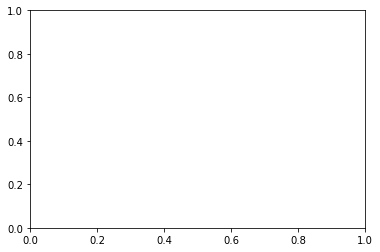

In [34]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Train loss")
plt.show()

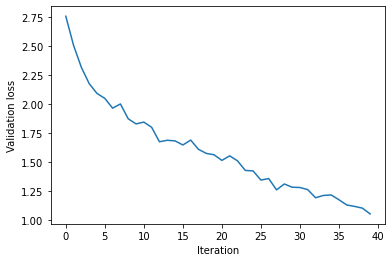

In [46]:
plt.plot(val_losses)
plt.xlabel("Iteration")
plt.ylabel("Validation loss")
plt.show()

In [ ]:
torch.cuda.empty_cache()


##  Visualizing the attentions
Defining helper functions
<li>Given the image generate captions and attention scores</li>
<li>Plot the attention scores in the image</li>

In [36]:
#generate caption
def get_caps_from(model, features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=test_dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()
    
def test_rand_image(model):
    dataiter = iter(test_loader)
    images,_ = next(dataiter)

    img = images[0].detach().clone()
    img1 = images[0].detach().clone()
    caps,alphas = get_caps_from(model, img.unsqueeze(0))

    plot_attention(img1, caps, alphas)
    


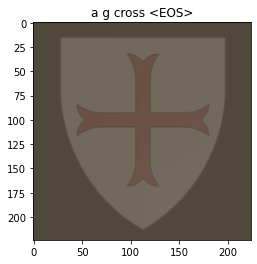

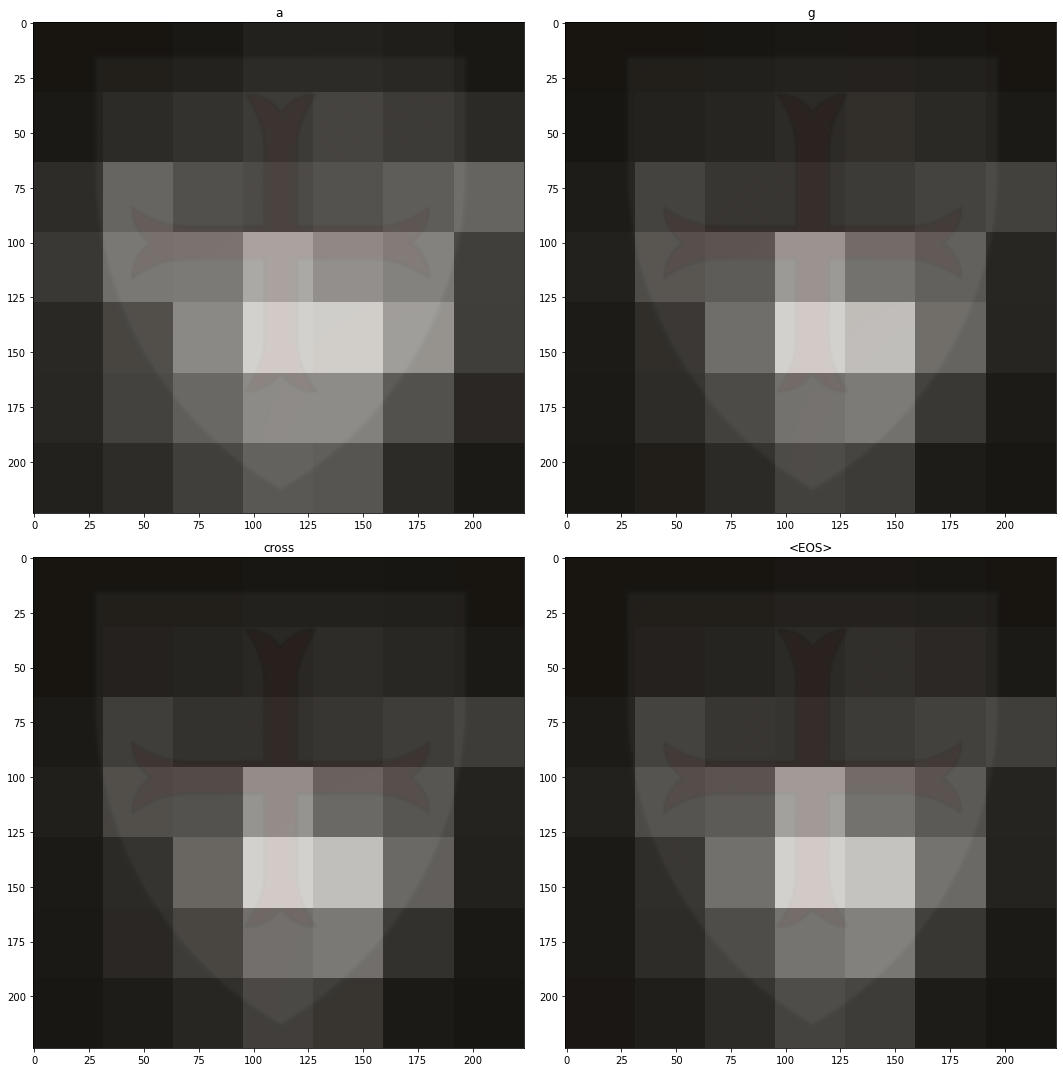

In [43]:
# torch.cuda.empty_cache()

# model_path = '/home/space/datasets/COA/models/baseline/attention_model_state.pth'
# local_model_path = 'simple-model.pth'
# model = load_model(local_model_path)
test_rand_image(model)